In [1]:
from collections import Counter
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras import backend as K
from keras import objectives
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


# Goal

I would like to experiment with variational autoencoders, and see whether we can take variational autoencoders VAEs and use them on protein sequences to get a mapping of sequence space in low dimensions. 

This is analogous to what I've done before using t-SNE, PCA and multi-dimensional scaling to get a 2-D projection of sequence space, but has an added advantage: VAEs learn a probability distribution over the embedded space, meaning I can sample new points from the 2D embedding to generate new sequences. 

## The Dataset

The dataset I am using here is H3N2 protein sequences from the Influenza Research Database, dating from the year 2000 to the year 2017. 

## VAEs

I will be using Keras to write the autoencoder. A lot of the code is borrowed heavily from the VAE tutorial on Keras' website.

At a higher level, I think VAEs have a few advantages over the t-SNE/MDS/PCA techniques. 

1. It's [injective](https://en.wikipedia.org/wiki/Injective_function). This means that not only can we learn about the embedding space and what it looks like, we can sample from the embedded space and try to generate new sequences from it. In contrast, t-SNE/MDS/PCA are not injective, meaning we can't do so. (I must clarify for myself the definition of "injective"; I learned about this point having asked on Stats StackExchange)

## Research Questions

1. Is there a pattern of protein evolution? Assuming fitness is correlated with the number of sequences (based on personal communication, this is only moderately true), can we plot the fitness of a cluster of viruses over time?
1. The dataset is temporal - that is, time (year) is attached to each sequence. Can we learn the embedding over time, perhaps enabling forecasting of future sequences?

In [2]:
# Load sequences using BioPython.
sequences = []
years = []
for s in SeqIO.parse('h3n2.fasta', 'fasta'):
    try:
        # assert len(s) == 566
        year = int(s.id.split('/')[-1])
        assert year in range(2000, 2018)
        
        sequences.append(s)
        years.append(year)
    except:
        pass

# Find distribution of lengths
lengths = [len(s) for s in sequences]
len_counts = Counter(lengths)
max(len_counts.keys())

570

In [3]:
# Sanity check: what is the distribution of sequences? It should be clustered around 566 a.a.
len_counts

Counter({565: 1, 566: 8349, 570: 1})

In [4]:
# Sanity check: make sure the number of sequences is the same as the number of "years" recorded.
len(sequences), len(years)

(8351, 8351)

In [5]:
# Pad sequences until they are of length max sequence length.
for s in sequences:
    while len(s) < max(len_counts.keys()):
        s.seq += '*'     

In [6]:
# Figure out how many unique letters are being used.
letters = set()
for s in sequences:
    letters = letters.union(s.seq)
print(letters, len(letters))

{'M', 'G', 'A', 'L', 'P', 'F', 'C', '*', 'V', 'K', 'N', 'Y', 'J', 'H', 'E', 'W', 'R', 'T', 'D', 'S', 'Q', 'X', 'B', 'I', 'Z'} 25


In [7]:
# Convert sequences into numpy array.
char_array = np.chararray(shape=(len(sequences), max(len_counts.keys())), unicode=True)
# arr = np.array([list(rec) for rec in sequences])
char_array
for i, seq in enumerate(sequences):
    char_array[i, :] = list(seq)

In [8]:
# Sanity check: shape should be correct - n_samples by max_length
char_array.shape

(8351, 570)

In [9]:
# Binarize the features to one-of-K encoding.
lb = LabelBinarizer()
lb.fit(list(letters))

input_array = np.zeros(shape=(char_array.shape[0], max(len_counts.keys()) * len(letters)))

# Sanity check: input_array should have width len(letters) * n_positions
print(input_array.shape)
for i in range(char_array.shape[1]):
    input_array[:, i*len(letters):(i+1)*len(letters)] = lb.transform(char_array[:, i])

(8351, 14250)


In [10]:
# Sanity check: there should only be 0s and 1s in the array
np.unique(input_array)

array([ 0.,  1.])

In [11]:
# Sanity check: in the first position (expanded to K positions), there should only be one slot of value "1".
input_array[0, 0:len(letters)]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

## Code VAE

Here we code up the variational autoencoder. The architecture is intentionally very simple: Directly compress the 14250-dimensions down to 2 dimensions, no intermediate representations. Diagrammatically:

    Original_Dim(14250) -> Latent_Dim(2) -> Original_Dim(14250)

In [38]:
# Set up VAE.
intermediate_dim = 1000
encoding_dim = 2
latent_dim = encoding_dim
epsilon_std = 1.0
nb_epoch = 250

x = Input(shape=(input_array.shape[1],))
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim, ), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


def vae_loss(x, x_decoded_mean):
    xent_loss = input_array.shape[1] * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_decoded_mean = Dense(input_array.shape[1], activation='sigmoid')(z_mean)

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
encoder_var = Model(x, z_log_var)

x_train, x_test = train_test_split(input_array)

early_stopping = EarlyStopping(monitor="val_loss", patience=2)

In [39]:
# build the decoder
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = vae.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [40]:
# Train the VAE to learn weights
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        validation_data=(x_test, x_test),
        callbacks=[early_stopping],
       )

Train on 6263 samples, validate on 2088 samples
Epoch 1/250
6263/6263 [==============================] - 2s - loss: 2308.0258 - val_loss: 750.1744

In [15]:
# Having learned the weights, now do one forward pass on the dataset. 
embeddings_mean = encoder.predict(input_array)
embeddings_var = encoder_var.predict(input_array)

In [16]:
# Sanity check: the width of the embeddings should be 2.
embeddings_mean.shape

(8351, 2)

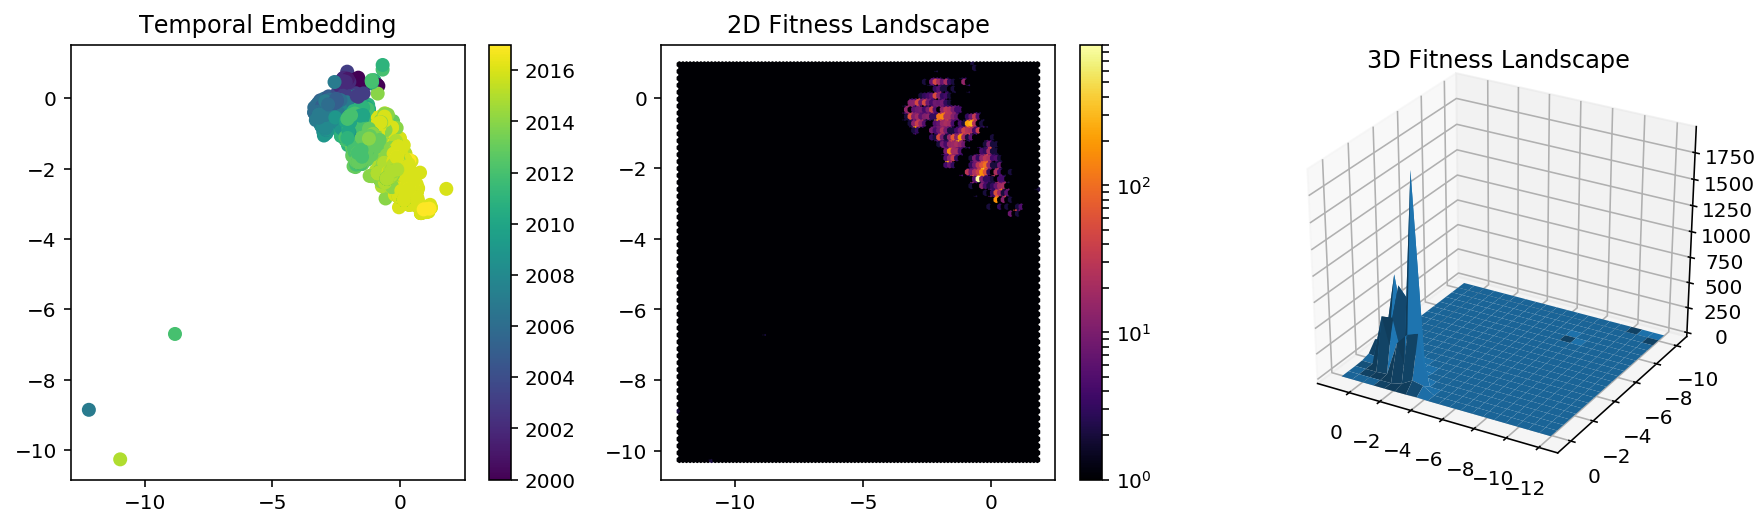

In [17]:
# Let's make a figure visualizing the embedding.
fig = plt.figure(figsize=(15,4))

# Scatter plot of the temporal embedding over time.
# X- and Y-axes are the embedding dimensions; color represents time.
ax1 = fig.add_subplot(1, 3, 1)
plt.scatter(embeddings_mean[:, 0], embeddings_mean[:, 1], c=years)
plt.colorbar(ax=ax1)
ax1.set_title('Temporal Embedding')

# Hexbin plot showing density of points on the 2D scatter. Higher intensity = more points.
ax2 = fig.add_subplot(1, 3, 2)
plt.hexbin(embeddings_mean[:, 0], embeddings_mean[:, 1], norm=colors.LogNorm(), cmap='inferno')
plt.colorbar(ax=ax2)
ax2.set_title('2D Fitness Landscape')

# 3D view of the embeddings. Just trying to visualize the data in an alternate fashion.
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
xs = embeddings_mean[:, 0]
ys = embeddings_mean[:, 1]
histo, xbins, ybins = np.histogram2d(xs, ys, bins=20)
xx, yy = np.meshgrid(xbins, ybins)
xx = xx[0:-1, :-1]
yy = yy[0:-1, :-1]
ax3.view_init(elev=30, azim=120)
ax3.plot_surface(xx, yy, histo)
ax3.set_title('3D Fitness Landscape')

# Save figure to disk.
plt.savefig('embedding-h3n2.pdf', bbox_inches='tight')

## Observations

1. Not sure what's going on with those points that are outside of the main cluster just yet. Raincheck: will investigate another day.
1. There appears to be a "vector" leading from early time to later time. Can investigate this below.
1. Fitness peaks and valleys seem to follow influenza cycles, but I wouldn't read too much into it just yet. See caveat point below.

## Caveats

The caveats to the fitness landscapes is clear: by plotting the histogram on the Z-axis, we are assuming that the number of sampled sequences equals to the prevalence (i.e. true fitness measure). Where prevalence not proportional to sampled number of sequences, this interpretation is invalid.

## Sampling New Sequences

Let's try sampling new sequences from the space of influenza protein sequences.

In [18]:
# Forward generate new sequences.
new_coords = np.array([[20, 20],
                       [20, 20]]).reshape(-1,2)

# new_seqs = np.rint(decoder.predict(new_coords))
new_seqs = decoder.predict(new_coords)

def numarr_to_letterarr(arr):
    """
    Converts numerical array to string array.
    """
    strings = np.chararray(shape=((arr.shape[0], int(arr.shape[1] / len(letters)))), unicode=True)
    for s in range(arr.shape[0]):
        seqlength = int(arr.shape[1] / len(letters))
        for i in range(seqlength):
            pos_arr = arr[:, i * len(letters): (i+1) * len(letters)]
            strings[:, i] = lb.inverse_transform(pos_arr)
    return strings

new_strarr = numarr_to_letterarr(new_seqs)
new_strarr

chararray([['*', '*', '*', ..., 'A', 'A', 'A'],
       ['*', '*', '*', ..., 'A', 'A', 'A']], 
      dtype='<U1')

In [19]:
def letter_arr_to_str(letter_array):
    """
    A function that allows us to sample from new sequence space. 
    
    Only does it one vector at a time.
    """
    return ''.join([i for i in letter_array])

letter_arr_to_str(new_strarr[0])

'**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************AAAA'

In [20]:
# Sanity check.
pos = 2
pos_enc = new_seqs[:, pos * len(letters):(pos+1) * len(letters)]
str(lb.inverse_transform(pos_enc)[0])

'*'

In [21]:
new_seqs.shape[1] / len(letters)

570.0

In [22]:
sequences[1813]

SeqRecord(seq=Seq('MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITSDRIEVTN...***', SingleLetterAlphabet()), id='A/Colorado/01/2017', name='A/Colorado/01/2017', description='A/Colorado/01/2017', dbxrefs=[])

In [23]:
reconstruct = numarr_to_letterarr(decoder.predict(encoder.predict(input_array[1813, :].reshape(1, -1))))[0]
reconstruct

chararray(['M', 'K', 'T', 'I', 'I', 'A', 'L', 'S', 'Y', 'I', 'L', 'C', 'L',
       'V', 'F', 'A', 'Q', 'K', 'I', 'P', 'G', 'N', 'D', 'N', 'S', 'T',
       'A', 'T', 'L', 'C', 'L', 'G', 'H', 'H', 'A', 'V', 'P', 'N', 'G',
       'T', 'I', 'V', 'K', 'T', 'I', 'T', 'N', 'D', 'R', 'I', 'E', 'V',
       'T', 'N', 'A', 'T', 'E', 'L', 'V', 'Q', 'N', 'S', 'S', 'I', 'G',
       'E', 'I', 'C', 'D', 'S', 'P', 'H', 'Q', 'I', 'L', 'D', 'G', 'E',
       'N', 'C', 'T', 'L', 'I', 'D', 'A', 'L', 'L', 'G', 'D', 'P', 'Q',
       'C', 'D', 'G', 'F', 'Q', 'N', 'K', 'K', 'W', 'D', 'L', 'F', 'V',
       'E', 'R', 'S', 'K', 'A', 'Y', 'S', 'N', 'C', 'Y', 'P', 'Y', 'D',
       'V', 'P', 'D', 'Y', 'A', 'S', 'L', 'R', 'S', 'L', 'V', 'A', 'S',
       'S', 'G', 'T', 'L', 'E', 'F', 'N', 'N', 'E', 'S', 'F', 'N', 'W',
       'T', 'G', 'V', 'T', 'Q', 'N', 'G', 'T', 'S', 'S', 'A', 'C', 'I',
       'R', 'R', 'S', 'S', 'S', 'S', 'F', 'F', 'S', 'R', 'L', 'N', 'W',
       'L', 'T', 'H', 'L', 'N', 'Y', 'T', 'Y', 'P', 'A', 'L'

In [24]:
for pos, letter in enumerate(str(sequences[1813].seq)):
    if letter == reconstruct[pos]:
        pass
    else:
        print(pos, letter)

46 S


In [25]:
# Let's sample some new sequences from around a 2017 one.
variances = encoder_var.predict(input_array[1813, :].reshape(1, -1))
means = encoder.predict(input_array[1813, :].reshape(1, -1))
def np_sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal(loc=0.,
                               scale=epsilon_std)
    return z_mean + np.exp(z_log_var / 2) * epsilon

new_starting_points = np_sampling([means, variances])
new_starting_points, means

(array([[ 1.23665893, -1.91219521]], dtype=float32),
 array([[ 0.21533282, -2.75880003]], dtype=float32))

In [26]:
from Levenshtein import distance

# Compute Levenshtein distance between a 2017 sequence and a new point sampled around it.
seq_coords = np.array([new_starting_points[0], means[0]])
seq_arrays = decoder.predict(seq_coords)
letter_arrays = numarr_to_letterarr(seq_arrays)

sequences = []
for row in range(letter_arrays.shape[0]):
    string = ''.join(letter for letter in letter_arrays[row])
    sequences.append(string)

distance(sequences[0], sequences[1])

9

Great stuff! Very low levenshtein distance, indicating sampling around the same spot gives very little mutations. I actually might want to characterize how the euclidean distance (continuous) varies with Levenshtein distance (discrete).

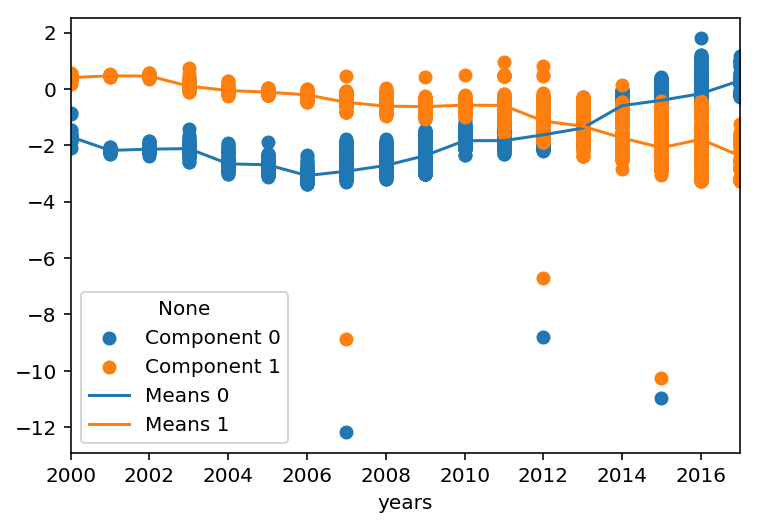

In [27]:
# Let's try doing some temporal scatterplots.

plt.scatter(years, embeddings_mean[:, 0], label='Component 0')
plt.scatter(years, embeddings_mean[:, 1], label='Component 1')
plt.legend(loc='lower left')
# plt.ylim(-5, 5)

# Let me try plotting just the means.
import pandas as pd

df = pd.DataFrame()
df['years'] = years
df['Means 0'] = embeddings_mean[:, 0]
df['Means 1'] = embeddings_mean[:, 1]

df.to_csv('embedding_vals.csv')

df.groupby('years').mean().plot(ax=plt.gca())

What should we do next? It looks to me that there might be a temporal trend that we can take advantage of. Component 0 is on an upward trend, while component 1 is on a downward trend (**note: I think there's very little physical meaning to a "component"**), so if we fit a gaussian process to the mean over each year, maybe we can make a prediction over the embeddings for the coming year. 

The process:

- GP fit to previous years.
- Compute 95% credible interval on 2018. 
- Sample new component values. Joint probability density over component values will give probability density over new sequences.

Okay - it means it's time to get learning how to get GPs working properly!

In [28]:
year_means_df = df.groupby('years').mean()
year_means_df.head()    

,Means 0,Means 1
years,,
2000,-1.693534,0.404879
2001,-2.178668,0.467721
2002,-2.132683,0.458797
2003,-2.115877,0.101572
2004,-2.653770,-0.053662


In [29]:
X = np.array(list(year_means_df.index))[:, None]
Y = year_means_df['Means 0'].values[:, None]
X

array([[2000],
       [2001],
       [2002],
       [2003],
       [2004],
       [2005],
       [2006],
       [2007],
       [2008],
       [2009],
       [2010],
       [2011],
       [2012],
       [2013],
       [2014],
       [2015],
       [2016],
       [2017]])

In [30]:
# import theano.tensor as tt
# with pm.Model() as model:
#     # priors on the covariance function hyperparameters
#     l = pm.Uniform('l', 0, 10)

#     # uninformative prior on the function variance
#     # log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
#     # s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))

#     # uninformative prior on the noise variance
#     log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
#     s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))

#     # covariance functions for the function f and the noise
#     f_cov = pm.gp.cov.Exponential(1, l)

#     y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, observed={'X':X, 'Y':Y})

In [31]:
# with model:
#     trace = pm.sample(2000)

In [32]:
# Z = np.linspace(min(X),max(X),100)[:, None]
